In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import shapely as shp
import geopandas as gpd
import math
import random
import scipy.stats as stats
from glob import glob
import os
#from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.tools.eval_measures import rmse

#PCA analysis
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn import metrics

from matplotlib.colors import LogNorm, Normalize

from functions import *

In [2]:
pal = sns.color_palette('YlGn', 5)
pal

[(0.9312572087658593, 0.973287197231834, 0.6980853517877739),
 (0.7359477124183007, 0.8915032679738563, 0.5843137254901961),
 (0.4672049211841599, 0.7748096885813149, 0.4727873894655901),
 (0.21568627450980393, 0.6196078431372549, 0.330718954248366),
 (0.04359861591695502, 0.442722029988466, 0.23063437139561707)]

### Data Imports

In [7]:
'''Import Data'''
path = './data/modeloutput/' # use your path
modDat = pd.read_csv(path + 'rhino-data/processedData.csv')

modDat = modDat.rename(columns = {'OLS.Prediction.Ring.5' : 'LAI', 
                                  'prop_Coniferous' : 'pCon'})

### Result Plots

In [8]:
#Model error vs pCo
modDat['pCo'] = modDat['Co']/modDat['n']
overlapMod2023 = smf.ols('maxDepth ~ OverlapMean', data = modDat[modDat.SYear == 2023]).fit()
overlapMod2024 = smf.ols('maxDepth ~ OverlapMean', data = modDat[modDat.SYear == 2024]).fit()
overlapMod = smf.ols('maxDepth ~ OverlapMean', data = modDat).fit()
laiMod2023 = smf.ols('maxDepth ~ LAI', data = modDat[modDat.SYear == 2023]).fit()
laiMod2024 = smf.ols('maxDepth ~ LAI', data = modDat[modDat.SYear == 2024]).fit()
laiMod = smf.ols('maxDepth ~ LAI', data = modDat).fit()

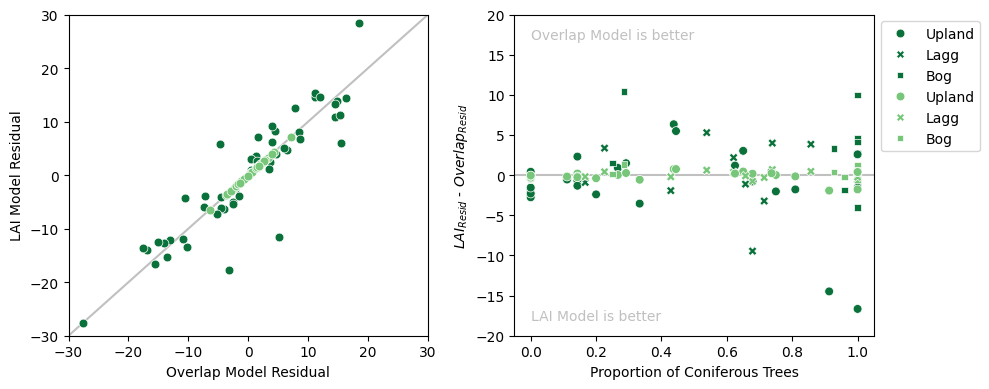

In [9]:
fig, [ax1, ax2] = plt.subplots(1, 2, figsize = (10, 4), 
                               #sharex = True, 
                               #sharey = True, 
                               layout = 'tight')

ax1.axline((0, 0), slope = 1, color = 'silver')

sns.scatterplot(x = overlapMod2023.resid, y = laiMod2023.resid, color = pal[4], 
            #hue = modDat[modDat.SYear == 2023].pCon,
            zorder = 2, s = 40, label = '2023', ax = ax1)
sns.scatterplot(x = overlapMod2024.resid, y = overlapMod2024.resid, color = pal[2],
            #hue = modDat[modDat.SYear == 2024].pCon,
            zorder = 2, s = 40, label = '2024', ax = ax1)

ax2.axhline(0, color = 'silver')
sns.scatterplot(x = modDat[modDat.SYear == 2023].pCon, y = laiMod2023.resid - overlapMod2023.resid, color = pal[4], 
            style = modDat[modDat.SYear == 2023].zones,
            zorder = 2, s= 40, ax = ax2)
sns.scatterplot(x = modDat[modDat.SYear == 2024].pCon, y = laiMod2024.resid - overlapMod2024.resid, color = pal[2],
            style = modDat[modDat.SYear == 2024].zones,
            zorder = 2, s = 40, ax = ax2)

ax1.set_xlim(-30, 30)
ax1.set_ylim(-30, 30)
ax2.set_ylim(-20, 20)
ax1.set_xlabel('Overlap Model Residual')
ax1.set_ylabel('LAI Model Residual')
ax2.set_xlabel('Proportion of Coniferous Trees')
ax2.set_ylabel(r'$LAI_{Resid}$ - $Overlap_{Resid}$')
ax2.text(0, -18, 'LAI Model is better', color = 'silver')
ax2.text(0, 17, 'Overlap Model is better', color = 'silver')
ax1.get_legend().remove()
ax2.legend(bbox_to_anchor = (1, 1))

plt.savefig('./figures/figure6-modelComparison.pdf', bbox_inches = 'tight')

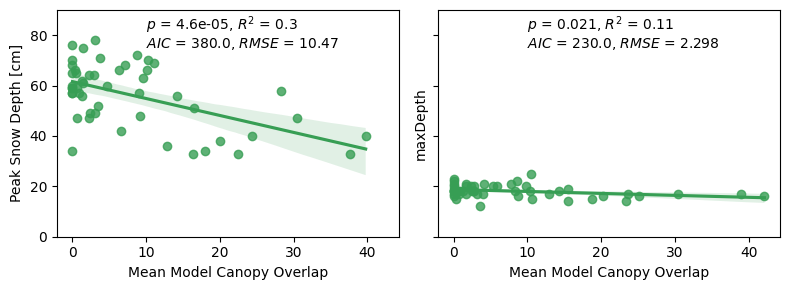

In [10]:

fig, [ax, ax2] = plt.subplots(1, 2, figsize = (8, 3), 
                              sharex = True, 
                              sharey = True, 
                              layout = 'tight')

overlapMod2023 = smf.ols('maxDepth ~ OverlapMean', data = modDat[modDat.SYear == 2023]).fit()
sns.regplot(data = modDat[modDat.SYear == 2023], x = 'OverlapMean', y = 'maxDepth',
            color = pal[3], 
            ax = ax)
ax.text(10, 82, r'$ p $ = ' + str(round_sig(overlapMod2023.pvalues.OverlapMean, 2)) + r', $ R^2 $ = ' + str(round_sig(overlapMod2023.rsquared, 2)))
ax.text(10, 75,
        r'$ AIC $ = ' + str(round_sig(overlapMod2023.aic, 2)) + r', $ RMSE $ = ' + str(round_sig(rmse(modDat[modDat.SYear == 2023].maxDepth, overlapMod2023.fittedvalues), 4)))

overlapMod2024 = smf.ols('maxDepth ~ OverlapMean', data = modDat[modDat.SYear == 2024]).fit()
sns.regplot(data = modDat[modDat.SYear == 2024], x = 'OverlapMean', y = 'maxDepth',
            color = pal[3], 
            ax = ax2)
ax2.text(10, 82, r'$ p $ = ' + str(round_sig(overlapMod2024.pvalues.OverlapMean, 2)) + r', $ R^2 $ = ' + str(round_sig(overlapMod2024.rsquared, 2)))
ax2.text(10, 75,
        r'$ AIC $ = ' + str(round_sig(overlapMod2024.aic, 2)) + r', $ RMSE $ = ' + str(round_sig(rmse(modDat[modDat.SYear == 2024].maxDepth, overlapMod2024.fittedvalues), 4)))

ax.set_ylabel('Peak Snow Depth [cm]')
ax.set_xlabel('Mean Model Canopy Overlap')
ax2.set_xlabel('Mean Model Canopy Overlap')
ax.set_ylim(0, 90)
plt.savefig('./figures/figure6-overlap_correlationPlot.pdf', bbox_inches = 'tight')

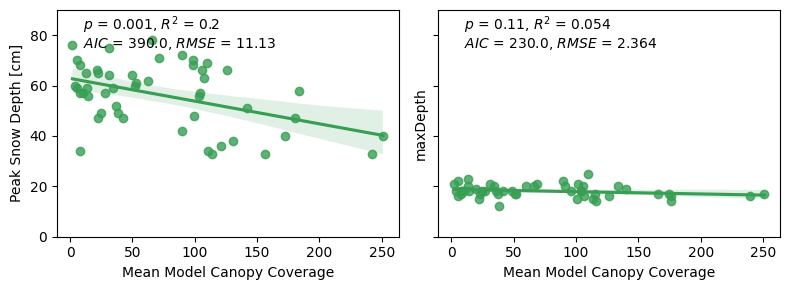

In [11]:

fig, [ax, ax2] = plt.subplots(1, 2, figsize = (8, 3), 
                              sharex = True, 
                              sharey = True, 
                              layout = 'tight')

totalMod2023 = smf.ols('maxDepth ~ UnionMean', data = modDat[modDat.SYear == 2023]).fit()
sns.regplot(data = modDat[modDat.SYear == 2023], x = 'UnionMean', y = 'maxDepth',
            color = pal[3], 
            ax = ax)
ax.text(10, 82, r'$ p $ = ' + str(round_sig(totalMod2023.pvalues.UnionMean, 2)) + r', $ R^2 $ = ' + str(round_sig(totalMod2023.rsquared, 2)))
ax.text(10, 75,
        r'$ AIC $ = ' + str(round_sig(totalMod2023.aic, 2)) + r', $ RMSE $ = ' + str(round_sig(rmse(modDat[modDat.SYear == 2023].maxDepth, totalMod2023.fittedvalues), 4)))

totalMod2024 = smf.ols('maxDepth ~ UnionMean', data = modDat[modDat.SYear == 2024]).fit()
sns.regplot(data = modDat[modDat.SYear == 2024], x = 'UnionMean', y = 'maxDepth',
            color = pal[3], 
            ax = ax2)
ax2.text(10, 82, r'$ p $ = ' + str(round_sig(totalMod2024.pvalues.UnionMean, 2)) + r', $ R^2 $ = ' + str(round_sig(totalMod2024.rsquared, 2)))
ax2.text(10, 75,
        r'$ AIC $ = ' + str(round_sig(totalMod2024.aic, 2)) + r', $ RMSE $ = ' + str(round_sig(rmse(modDat[modDat.SYear == 2024].maxDepth, totalMod2024.fittedvalues), 4)))

ax.set_ylabel('Peak Snow Depth [cm]')
ax.set_xlabel('Mean Model Canopy Coverage')
ax2.set_xlabel('Mean Model Canopy Coverage')
ax.set_ylim(0, 90)
plt.savefig('./figures/figure5-coverage_correlationPlot.pdf', bbox_inches = 'tight')